In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset


%matplotlib widget
%load_ext autoreload
%autoreload 2
from stressgait_analysis.gait_helper_functions import compute_HS
import numpy as np

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

In [4]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)


# Gait variability between strides

compute with coefficient of variation based on Winter, 2009

In [5]:
kinematics = dataset.kinematics.droplevel(level="bout")
kinematics

hip_flexion  \
participant condition speed cycle_idx percentage_of_stride                
VP_01       omc       slow  0         0                       15.617907   
                                      1                       14.898942   
                                      2                       14.222986   
                                      3                       13.644998   
                                      4                       13.199635   
...                                                                 ...   
VP_47       omc       fast  200       96                      19.179123   
                                      97                      19.724742   
                                      98                      20.170698   
                                      99                      20.258313   
                                      100                     20.283606   

                                                            knee_flexion  \
participant condition speed cycle_idx percentage_of_stride                 
VP_01       omc       slow  0         0                         5.708224   
                                      1                         5.079829   
                                      2                         4.740407   
                                      3                         5.059201   
                                      4                         5.675398   
...                                                                  ...   
VP_47       omc       fast  200       96                       13.579015   
                                      97                       11.883767   
                                      98                       10.334821   
                                      99                        9.310462   
                                      100                       8.377337   

                                                            ankle_plantarflexion  \
participant condition speed cycle_idx percentage_of_stride                         
VP_01       omc       slow  0         0                                -2.004872   
                                      1                                -1.608928   
                                      2                                -1.238677   
                                      3                                -0.926947   
                                      4                                -0.578666   
...                                                                          ...   
VP_47       omc       fast  200       96                               -1.871226   
                                      97                               -2.327794   
                                      98                               -2.870392   
                                      99                               -3.360518   
                                      100                              -3.841520   

                                                            elbow_flexion_angles  \
participant condition speed cycle_idx percentage_of_stride                         
VP_01       omc       slow  0         0                                 4.229529   
                                      1                                 3.657486   
                                      2                                 3.151685   
                                      3                                 2.796768   
                                      4                                 2.593602   
...                                                                          ...   
VP_47       omc       fast  200       96                               11.669596   
                                      97                               11.353260   
                                      98                               11.109806   
                                      99                               11.0689

In [6]:
def compute_cv(trial):

    std_trial = trial.groupby(["percentage_of_stride"]).std()
    mean_trial = trial.groupby(["percentage_of_stride"]).mean()

    mean_std_squared = std_trial.pow(2).mean()
    return np.sqrt(mean_std_squared) / mean_trial.mean()



In [14]:
cv = kinematics.groupby(["participant", "condition", "speed"]).apply(compute_cv)
cv_per_person = cv.groupby(["participant", "condition"]).mean()
cv_per_person

,,hip_flexion,knee_flexion,ankle_plantarflexion,elbow_flexion_angles,arm_swing_angles
participant,condition,,,,,
VP_01,omc,0.265311,0.079965,-0.602537,0.170125,0.169882
VP_02,control,0.177644,0.088370,-96.974323,0.072984,0.154045
VP_05,control,1.751908,0.111459,-10.989434,0.135479,0.163747
VP_06,omc,0.562728,0.133299,-0.572664,0.104405,0.210278
VP_07,control,0.428379,0.184728,2.089428,0.362668,0.387162
VP_08,control,12.013412,0.284997,-41.836674,1.668882,1.501839
VP_10,omc,0.195774,0.110052,-0.395884,0.495386,0.330841
VP_11,control,0.209738,0.102142,-0.357012,0.514379,0.340153
VP_12,control,0.155770,0.107692,-0.408330,0.503158,0.396526


In [8]:
cv = cv_per_person.groupby(["condition"]).mean()

In [9]:
cv

,hip_flexion,knee_flexion,ankle_plantarflexion,elbow_flexion_angles,arm_swing_angles
condition,,,,,
control,1.32066,0.123589,-8.038561,0.435978,0.431927
omc,0.84009,0.132729,1.480692,0.243298,0.295147


In [15]:
df_long = cv_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle_cv",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)

<Axes: xlabel='angle_cv', ylabel='value'>

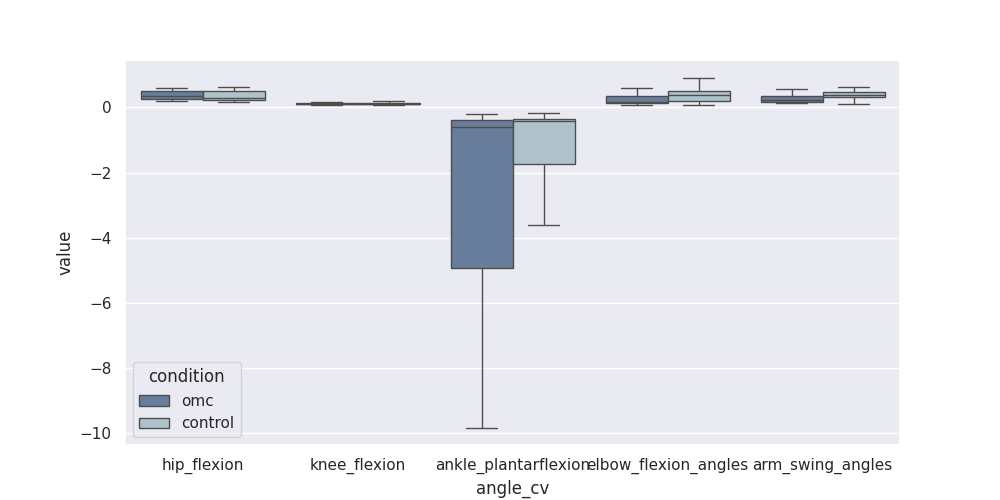

In [16]:
plt.figure()
sns.boxplot(x="angle_cv", y="value", hue="condition", data=df_long,showfliers=False)

In [18]:
from scipy.stats import shapiro

# Apply Shapiro-Wilk test to each angle column, grouped by condition
normality_results = cv_per_person.groupby('condition').apply(
    lambda g: g.drop(columns=['participant']).apply(
        lambda x: shapiro(x)[1]  # Get only the p-value
    )
).T  # transpose for cleaner view

normality_results.columns.name = None
normality_results

KeyError: "['participant'] not found in axis"

In [19]:
results = []
for c in cv_per_person.columns:
    ttest_results = pg.pairwise_tests(
        data=cv_per_person.reset_index(),                     # wide-format dataframe
        dv=c, # all angle columns
        between='condition',
       alpha=0.05/5, parametric=False)
    ttest_results["joint"] = c# optional: Cohen’s d effect size
    results.append(ttest_results)

anglewise_stats = pd.concat(results, ignore_index=True)

In [20]:
anglewise_stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,joint
0,condition,control,omc,False,False,185.0,two-sided,0.522817,0.209270,hip_flexion
1,condition,control,omc,False,False,199.0,two-sided,0.784191,-0.155932,knee_flexion
2,condition,control,omc,False,False,228.0,two-sided,0.648077,-0.485577,ankle_plantarflexion
3,condition,control,omc,False,False,279.0,two-sided,0.073999,0.671017,elbow_flexion_angles
4,condition,control,omc,False,False,286.0,two-sided,0.048931,0.573351,arm_swing_angles


# withon stride

swing amplitude / ROM

In [45]:
def rom(trial):
    max = trial.groupby(["cycle_idx"]).max()
    min = trial.groupby(["cycle_idx"]).min()


    return np.mean(max - min, axis=0)


rom = kinematics.groupby(["participant", "condition", "speed"]).apply(rom)
rom_per_person = rom.groupby(["participant", "condition"]).mean().loc[:,["elbow_flexion_angles", "arm_swing_angles"]]
rom_per_person

,,elbow_flexion_angles,arm_swing_angles
participant,condition,,
VP_01,omc,24.250830,26.284238
VP_02,control,16.001519,19.609559
VP_05,control,21.581337,33.644140
VP_06,omc,16.800313,26.860751
VP_07,control,24.621805,26.345384
VP_08,control,17.334168,17.148378
VP_10,omc,33.879216,35.562168
VP_11,control,22.959218,25.480965
VP_12,control,21.082809,29.453235


In [46]:
rom_per_person.groupby(["condition"]).mean()

,elbow_flexion_angles,arm_swing_angles
condition,,
control,21.180742,25.197553
omc,20.073605,26.591669


In [47]:
df_long = rom_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle_rom",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)

<Axes: xlabel='angle_rom', ylabel='value'>

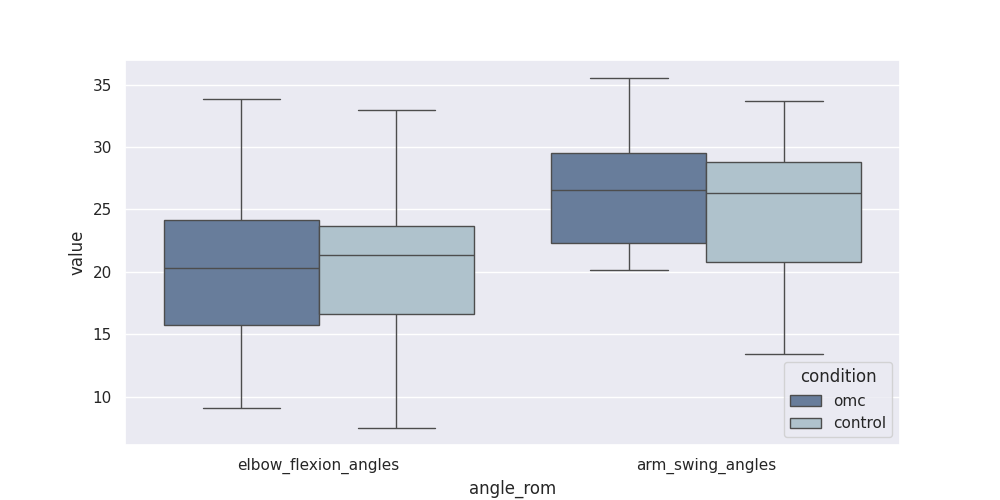

In [48]:
plt.figure()
sns.boxplot(x="angle_rom", y="value", hue="condition", data=df_long,showfliers=False)

In [49]:
results = []
for c in rom_per_person.columns:
    ttest_results = pg.pairwise_tests(
        data=rom_per_person.reset_index(),                     # wide-format dataframe
        dv=c, # all angle columns
        between='condition',
       alpha=0.05/2, parametric=False)
    ttest_results["joint"] = c# optional: Cohen’s d effect size
    results.append(ttest_results)

anglewise_stats = pd.concat(results, ignore_index=True)

In [50]:
anglewise_stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,joint
0,condition,control,omc,False,False,232.0,two-sided,0.574959,0.171050,elbow_flexion_angles
1,condition,control,omc,False,False,182.0,two-sided,0.473216,-0.258276,arm_swing_angles


within - stride - variance


In [63]:
def within_var(trial):
    var = trial.std(axis=0)


    return var


var_within = kinematics.groupby(["participant", "condition", "speed"]).apply(within_var)
var_per_person = var_within.groupby(["participant", "condition"]).mean().loc[:,["elbow_flexion_angles", "arm_swing_angles"]]
var_per_person


,,elbow_flexion_angles,arm_swing_angles
participant,condition,,
VP_01,omc,8.217984,8.302225
VP_02,control,4.977053,6.638317
VP_05,control,7.248033,11.057555
VP_06,omc,5.594785,8.801959
VP_07,control,11.645532,9.419555
VP_08,control,33.989650,16.679697
VP_10,omc,14.237145,11.950792
VP_11,control,11.939698,8.689767
VP_12,control,9.040960,10.342381


<Axes: xlabel='angle_rom', ylabel='value'>

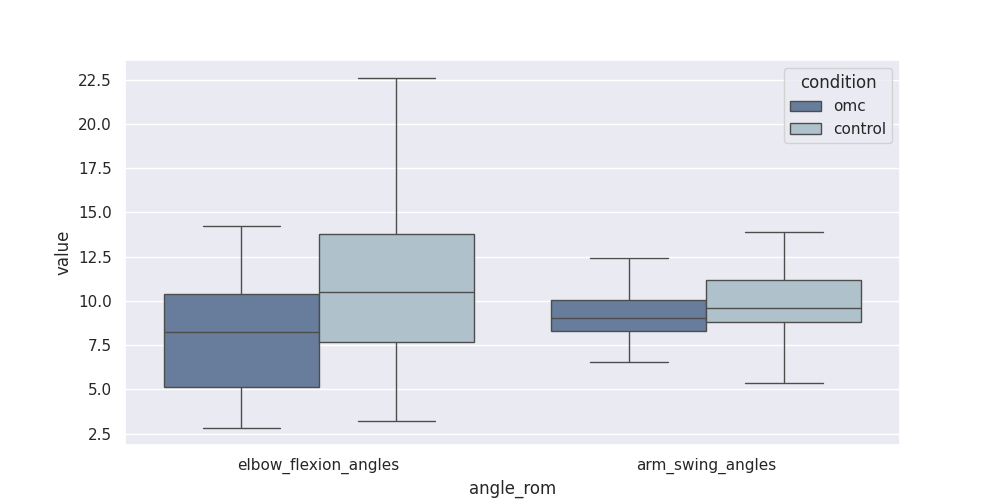

In [64]:
var_per_person.groupby(["condition"]).mean()
df_long = var_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle_rom",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)
plt.figure()
sns.boxplot(x="angle_rom", y="value", hue="condition", data=df_long, showfliers=False)

In [65]:
results = []
for c in var_per_person.columns:
    ttest_results = pg.pairwise_tests(
        data=var_per_person.reset_index(),                     # wide-format dataframe
        dv=c, # all angle columns
        between='condition',
       alpha=0.05/2, parametric=False)
    ttest_results["joint"] = c# optional: Cohen’s d effect size
    results.append(ttest_results)

anglewise_stats = pd.concat(results, ignore_index=True)

In [66]:
anglewise_stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,joint
0,condition,control,omc,False,False,289.0,two-sided,0.040615,0.754261,elbow_flexion_angles
1,condition,control,omc,False,False,233.0,two-sided,0.557307,0.167267,arm_swing_angles
